# Spatial Target Cells

Analyses for if cells care about the spatial target.

Open Questions:
- How to deal with stationary time during the spatial target analysis?
    - Note: in the current analysis, we are not dropping stationary times in the main analyses

In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np

from convnwb.io import load_nwbfile

from spiketools.measures.trials import compute_segment_frs
from spiketools.measures.conversions import convert_times_to_rates
from spiketools.measures.collections import detect_empty_time_ranges
from spiketools.spatial.occupancy import compute_bin_counts_assgn, compute_bin_edges, compute_bin_assignment
from spiketools.spatial.information import compute_spatial_information
from spiketools.spatial.utils import compute_nbins, compute_pos_ranges, convert_2dindices
from spiketools.spatial.target import compute_target_bins
from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.permutations import compute_surrogate_stats
from spiketools.plts.data import plot_bar
from spiketools.plts.spatial import plot_heatmap, plot_positions, create_heat_title
from spiketools.plts.utils import make_axes
from spiketools.plts.annotate import color_pvalue
from spiketools.utils import set_random_seed
from spiketools.utils.data import compute_range
from spiketools.utils.extract import (get_range, get_value_by_time, get_values_by_time_range,
                                      get_values_by_times, threshold_spikes_by_times)
from spiketools.utils.epoch import epoch_data_by_range, epoch_spikes_by_segment

In [3]:
import seaborn as sns
sns.set_context('talk')

In [4]:
import sys
sys.path.append('../code')
from models import create_df_target, fit_anova_target

## Settings

In [5]:
# Set random seed, for consistency shuffling
set_random_seed(101)

In [6]:
# Define the base data folder
#data_folder = '/Users/tom/Data/JacobsLab/WVTH/nwb'
data_folder = '/data12/jacobs_lab/WVTH/nwb'

In [7]:
# Define session information
session = {
    'experiment' : 'THF',
    'subject' : 'wv001',
    'session' : 2
}

In [8]:
# Define binning for chests (spatial target)
chest_bins = [5, 7]
#chest_bins = [6, 8]
n_bins = compute_nbins(chest_bins)

In [9]:
# Shuffle Settings
shuffle_approach = 'BINCIRC'  # 'CIRCULAR', 'BINCIRC'
n_surrogates = 25

if shuffle_approach == 'CIRCULAR':
    shuffle_kwargs = {}
    #shuffle_kwargs = {'shuffle_min' : 20000}
if shuffle_approach == 'BINCIRC':
    shuffle_kwargs = {}

In [10]:
# Define any quality measures
empty_time_bin = 0.25

In [11]:
# Set example unit to analyze
uind = 36

In [12]:
# Set which analysis method to run
METHOD = 'INFO'  # 'INFO' / 'ANOVA'

## Load Data

In [13]:
# Load NWB file
nwbfile = load_nwbfile(session, data_folder)

#### Get Trial Data

In [14]:
# Get the number of trials
n_trials = len(nwbfile.trials)
print('Number of trials: {}'.format(n_trials))

Number of trials: 24


In [15]:
# Get task time range
task_range = [0, nwbfile.trials.stop_time[-1]]

In [16]:
# Extract behavioural markers of interest
nav_starts = nwbfile.trials['navigation_start'].data[:]
chest_openings = nwbfile.trials['chest_opening_time'][:]

In [17]:
# Define the segment times of interest
seg_times = np.insert(np.array(chest_openings), 0, nav_starts, axis=1)

#### Get Spiking Data

In [18]:
# Check the number of units & keep indices
n_units = len(nwbfile.units)
keep_inds = np.where(nwbfile.units.keep[:])[0]
n_keep = len(keep_inds)
print('Number of units: {}'.format(n_units))
print('Number to keep:  {}'.format(n_keep))

Number of units: 81
Number to keep:  57


In [19]:
# Detect any empty ranges in the recording, and add them to shuffle arguments
empty_ranges = detect_empty_time_ranges(\
    [nwbfile.units.get_unit_spike_times(ii) for ii in keep_inds], empty_time_bin, task_range)
shuffle_kwargs['drop_time_range'] = empty_ranges

/home1/tom.donoghue/.conda/envs/thproj/lib/python3.8/site-packages/spiketools/utils/checks.py:232: UserWarning: The data values extend beyond the given bin definition.
  warnings.warn(msg)


In [20]:
# Get spikes
spikes = nwbfile.units.get_unit_spike_times(uind)

#### Get Position Data

In [21]:
# Extract the position data
ptimes = nwbfile.acquisition['position']['player_position'].timestamps[:] 
positions = nwbfile.acquisition['position']['player_position'].data[:]

In [22]:
# Get the chest positions & trial indices
chest_positions = nwbfile.acquisition['stimuli']['chest_positions'].data[:]
chest_trials = nwbfile.trials.chest_trials[:]

## Chest Positions

In [23]:
# Check chest position range
ch_xrange, ch_yrange = compute_pos_ranges(chest_positions)
print('Chest X position range: {:1.2f} - {:1.2f}'.format(*ch_xrange))
print('Chest Y position range: {:1.2f} - {:1.2f}'.format(*ch_yrange))

Chest X position range: 362.86 - 406.85
Chest Y position range: 321.34 - 396.47


In [24]:
# Check traversal position range
pos_xrange, pos_yrange = compute_pos_ranges(positions)
print('Position X range: {:1.2f} - {:1.2f}'.format(*pos_xrange))
print('Position X range: {:1.2f} - {:1.2f}'.format(*pos_yrange))

Position X range: 365.40 - 404.59
Position X range: 285.00 - 433.00


In [25]:
# Select the position values for navigation periods
_, positions_trials = epoch_data_by_range(ptimes, positions,
                                          nwbfile.trials.navigation_start[:],
                                          nwbfile.trials.navigation_stop[:])

In [26]:
# Get area ranges, adding a buffer to the z-range (for tower transport)
area_range = [[360, 410], [320, 400]]
#area_range = [nwbfile.acquisition['boundaries']['x_range'].data[:],
#              nwbfile.acquisition['boundaries']['z_range'].data[:] + np.array([-15, 15])]

In [27]:
# Compute edges for chest binning
x_edges, y_edges = compute_bin_edges(positions, chest_bins, area_range=area_range)

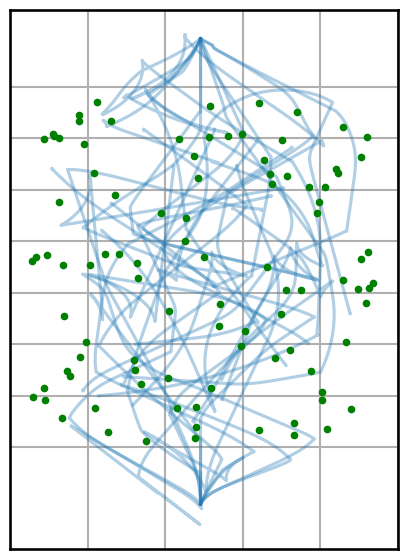

In [28]:
# Plot the subject positions, overlaid with chest positions
landmarks = {'positions' : chest_positions, 'color' : 'green'}
plot_positions(positions_trials, landmarks=landmarks,
               x_bins=x_edges, y_bins=y_edges, figsize=(5, 7))

In [29]:
# Assign each chest to a bin, and collect together 
ch_xbin, ch_ybin = compute_bin_assignment(chest_positions, x_edges, y_edges)
#ch_bins2d = np.array([ch_xbin, ch_ybin]) # TEMP

In [30]:
# Compute the 1d equivalent of the 2d indices
chbins = convert_2dindices(ch_xbin, ch_ybin, chest_bins)

In [31]:
# Compute chest occupancy
chest_occupancy = compute_bin_counts_assgn(chest_bins, ch_xbin, ch_ybin)

In [32]:
# Check the number of chests per bin
print("Range of chests per bin: {:1.0f} - {:1.0f}".format(*compute_range(chest_occupancy)))

Range of chests per bin: 0 - 6


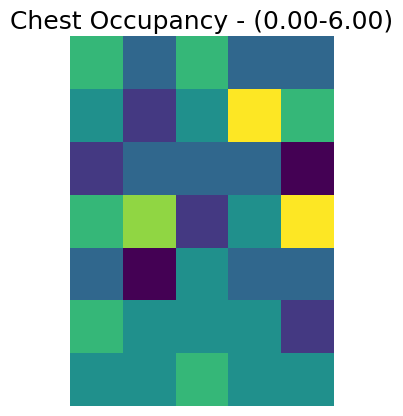

In [33]:
# Plot chest occupancy
plot_heatmap(chest_occupancy, title=create_heat_title('Chest Occupancy', chest_occupancy))

## Single Trial

In [34]:
# Get trial information
t_ind = 2
t_st = nwbfile.trials['navigation_start'][t_ind]
ch_openings = nwbfile.trials['chest_opening_time'][t_ind]
t_en = ch_openings[-1]

In [35]:
# Get the chests for the current trial
t_mask = chest_trials == t_ind

In [36]:
# Select chest openings for the current trial
t_time, t_pos = get_values_by_time_range(ptimes, positions, t_st, t_en)
ch_times = np.array([get_value_by_time(t_time, t_pos, ch_op) for ch_op in ch_openings])

In [37]:
# Get spikes from the selected trial time
t_spikes = get_range(spikes, t_st, t_en)
t_spike_positions = get_values_by_times(t_time, t_pos, t_spikes, threshold=0.25)

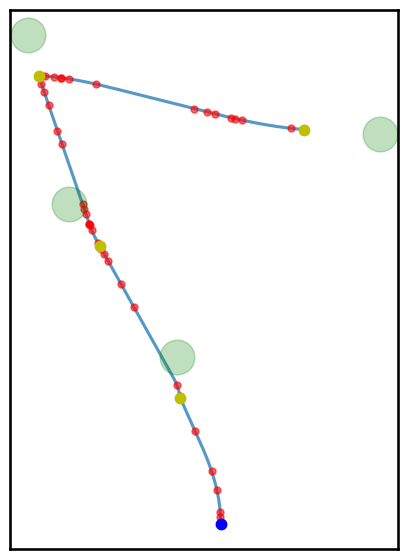

In [38]:
# Plot an encoding trial: with traversals, chest locations, and spike firing
tspikes = {'positions' : t_spike_positions, 'ms' : 10, 'alpha' : 0.6}
landmarks = [{'positions' : chest_positions[t_mask, :],
              'color' : 'green', 'ms' : 50, 'alpha' : 0.25},
             {'positions' : np.atleast_2d(t_pos[0, :]), 'color' : 'blue', 'ms' : 15},
             {'positions' : ch_times, 'color' : 'y', 'ms' : 15}]
plot_positions(t_pos, tspikes, landmarks, alpha=0.75, figsize=(5, 7))

In [39]:
# Select spikes from the trial that have position values
selected_spikes = threshold_spikes_by_times(t_spikes, t_time, 0.25)

In [40]:
# Check the number of spikes per segment (this should align with whats plotted above)
seg_spikes = epoch_spikes_by_segment(selected_spikes, seg_times[t_ind, :])
print([len(seg) for seg in seg_spikes])

[8, 13, 16, 18]


In [41]:
# Check that the number of selected spikes matches the segment spikes
assert len(selected_spikes) == sum([len(seg) for seg in seg_spikes])

In [42]:
# Compute the firing rate across 
trial_frs = convert_times_to_rates(selected_spikes, seg_times[t_ind, :])

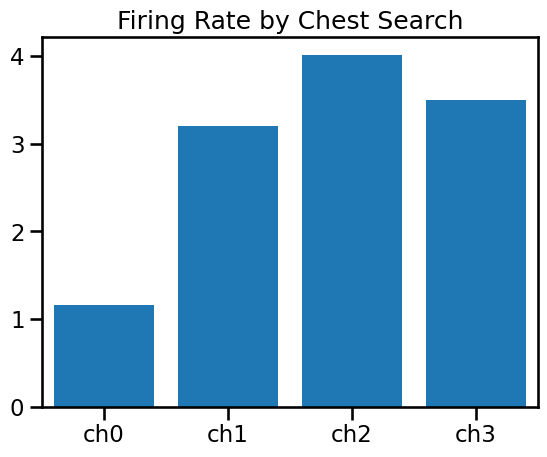

In [43]:
# Plot the firing rate by chest search, for a single trial
plot_bar(trial_frs, title='Firing Rate by Chest Search', labels=['ch0', 'ch1', 'ch2', 'ch3'])

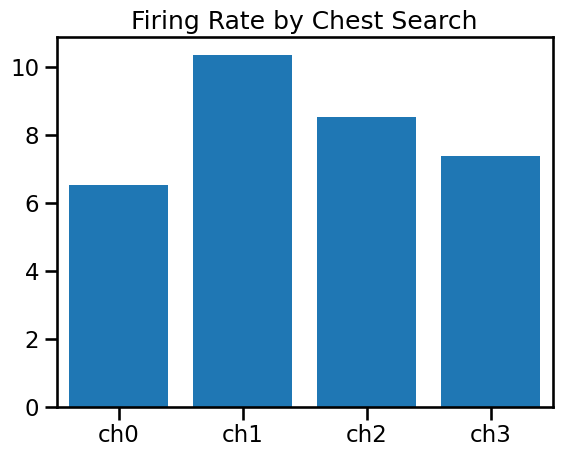

In [44]:
# Compare with firing rate for all spikes in each segment (including stationary periods)
trial_frs_all = convert_times_to_rates(t_spikes, seg_times[t_ind, :])
plot_bar(trial_frs_all, title='Firing Rate by Chest Search', labels=['ch0', 'ch1', 'ch2', 'ch3'])

## Spatial Target Bins

In [45]:
# Compute the segment firing rate per chest segment, per trial
target_frs = compute_segment_frs(spikes, seg_times)

In [46]:
# Compute the average firing across spatial target bins
target_bins = compute_target_bins(target_frs, chest_bins, ch_xbin, ch_ybin, chest_occupancy)

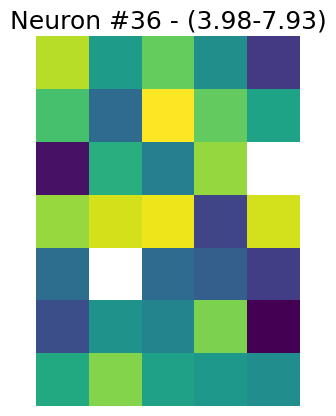

In [47]:
# Check the firing rate per spatial target for an example neuron
plot_heatmap(target_bins, title=create_heat_title('Neuron #{}'.format(uind), target_bins))

## Statistical Analyses

In [48]:
# Create shuffles
times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates, **shuffle_kwargs)

## Spatial Information

In [49]:
# Compute spatial information for the target firing
spike_info = compute_spatial_information(target_bins, chest_occupancy)
print(spike_info)

0.018161131614056355


In [50]:
# Compute spatial information measures on surrogates
surrs = np.zeros(n_surrogates)
for ind, stimes in enumerate(times_shuffle):
    surr_target_frs = compute_segment_frs(stimes, seg_times)
    surr_target_bins = compute_target_bins(surr_target_frs, chest_bins, ch_xbin, ch_ybin, chest_occupancy)
    surrs[ind] = compute_spatial_information(surr_target_bins, chest_occupancy)

In [51]:
# Compute surrogate statistics
p_val, z_score = compute_surrogate_stats(spike_info, surrs, verbose=True)

p-value: 0.32
z-score: 0.40


## ANOVA

In [52]:
# Create dataframe, with 1d (flattened) spatial bin labels
df = create_df_target({'trial' : chest_trials,
                       'target_bin' : chbins,
                       'fr' : target_frs.flatten()})

In [53]:
# Fit the ANOVA, and get the f-value
f_val = fit_anova_target(df)
f_val

1.4046528554094506

In [54]:
# Compute measures on surrogates
surrogates = np.zeros(n_surrogates)
for ind, shuffle in enumerate(times_shuffle):
    df_shuffle = create_df_target({'trial' : chest_trials, 'target_bin' : chbins,
                                   'fr' :compute_segment_frs(shuffle, seg_times).flatten()})
    surrogates[ind] = fit_anova_target(df_shuffle)

In [55]:
# Compute statistics on the surrogates
p_val, z_score = compute_surrogate_stats(f_val, surrogates, verbose=True)

p-value: 0.32
z-score: 0.29


In [56]:
# Possible alternative: dataframe with 2d (x & y) bins
# df = create_df_target({'trial' : chest_trials, 'chest_xbin' : ch_xbin,
#                        'chest_ybin' : ch_ybin, 'fr' :seg_frs})
# note: this needs a new model fitting function, if is to be used

## All Cells

In [57]:
# # Plot spatial target heat maps for all cells
# for ii, ax in zip(keep_inds, make_axes(n_keep, hspace=0.4, wspace=0.4)):

#     uspikes = nwbfile.units.get_unit_spike_times(ii)

#     # Compute spatial target segment firing, and overall binned firing
#     target_frs = compute_segment_frs(uspikes, seg_times)
#     target_bins = compute_target_bins(target_frs, chest_bins, ch_xbin, ch_ybin, chest_occupancy)

#     # Compute real data value
#     if METHOD == 'INFO':
#         data_value = compute_spatial_information(target_bins, chest_occupancy)

#     if METHOD == 'ANOVA':
#         data_df = create_df_target({'trial' : chest_trials, 'target_bin' : chbins, 'fr' : target_frs.flatten()})
#         data_value = fit_anova_target(data_df)

#     # Compute measures on surrogates
#     surrogates = np.zeros(n_surrogates)
#     times_shuffle = shuffle_spikes(uspikes, shuffle_approach, n_surrogates, **shuffle_kwargs)
#     for ind, shuffle in enumerate(times_shuffle):

#         surr_target_frs = compute_segment_frs(shuffle, seg_times)

#         if METHOD == 'INFO':  
#             starget_bins = compute_target_bins(surr_target_frs, chest_bins, ch_xbin, ch_ybin, chest_occupancy)
#             surrogates[ind] = compute_spatial_information(starget_bins, chest_occupancy)

#         if METHOD == 'ANOVA':
#             surrogates[ind] = fit_anova_target(create_df_target({'trial' : chest_trials,
#                                                                  'target_bin' : chbins,
#                                                                  'fr' : surr_target_frs.flatten()}))

#     # Compute z-score & p-value based on surrogates
#     p_val, z_score = compute_surrogate_stats(data_value, surrogates, plot=False, ax=ax)

#     # Plot target location heatmap
#     plot_heatmap(target_bins, title=create_heat_title('U{}'.format(ii), target_bins, z_score, p_val),
#                  title_color=color_pvalue(p_val), title_fontsize=12, ax=ax)